![](../images/bunker_neve.jpeg)
<br>
Photo: [*The Bunker*](https://www.thebunkerstudio.com/)

# The Sound of Science
### Notebook 2: Feature Engineering & Metric Comparisons
#### Adam Zucker
---

## Contents
- **Section 1:** Package and data imports, preprocessing
- **Section 2:** Comparing Spotify metrics with Librosa metrics
- **Section 3:** Engineering conversions between Librosa and Spotify

---
---
### Section 1
#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import os
import IPython.display as ipd

import spotipy
import librosa as lib
import librosa.display as libd

---

**BELOW:** Importing cleaned Spotify song dataset, sourced from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv). Some brief descriptions of less tangible features, as defined by [Spotify](https://developer.spotify.com/documentation/web-api/reference/):
- **Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- **Danceability:** How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 
- **Energy:** A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **Instrumentalness:** Predicts whether a track contains vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 dB.
- **Popularity:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g., the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
- **Speechiness:** Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g., talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g., sad, depressed, angry).

In [2]:
# Importing cleaned Spotify dataframe
df = pd.read_csv('../data_clean/spotify_kg_master.csv')
df.head()

,name,artists,tempo,key,mode,full_key,secondary_key,secondary_mode,secondary_full_key,loudness,...,instrumentalness,speechiness,acousticness,danceability,valence,popularity,liveness,year,id,duration_s
0,Thunderstruck,['AC/DC'],133.5,4,1,E major,1,0,C# minor,-5.175,...,0.01170,0.0364,0.000147,0.502,0.259,83,0.217,1990,57bgtoPSgt236HzfBOd8kj,292.9
1,The Gift of Love,['Bette Midler'],157.5,8,1,G# major,5,0,F minor,-10.765,...,0.00000,0.0287,0.359000,0.486,0.286,38,0.110,1990,7FUc1xVSKvABmVwI6kS5Y4,241.6
2,Thelma - Bonus Track,['Paul Simon'],94.0,5,1,F major,2,0,D minor,-13.367,...,0.08450,0.0770,0.872000,0.710,0.882,29,0.093,1990,7pcEC5r1jVqWGRypo9D7f7,254.7
3,How I Need You,['Bad Boys Blue'],123.1,9,0,A minor,0,1,C major,-12.096,...,0.00347,0.0398,0.072400,0.652,0.963,44,0.119,1990,1yq8h4zD0IDT5X1YTaEwZh,218.3
4,Nunca Dudes De Mi,['El Golpe'],143.1,4,1,E major,1,0,C# minor,-8.606,...,0.00000,0.0295,0.151000,0.476,0.514,31,0.305,1990,5kNYkLFs3WFFgE6qhfWDEm,176.0


In [3]:
df.shape

(56798, 21)

---
---
### Section 2
#### Metric Comparison

In [4]:
# Creating a small dataframe of songs I know well to test Spotify metrics against those generated by Librosa.
spotify_metrics_test_df = pd.concat((df[51917:51918], df[51440:51441], df[55871:55872], df[36982:36983],
                                     df[43245:43246], df[48257:48258], df[40585:40586], df[46528:46529],
                                     df[40245:40246], df[12541:12542]))

spotify_metrics_test_df

,name,artists,tempo,key,mode,full_key,secondary_key,secondary_mode,secondary_full_key,loudness,...,instrumentalness,speechiness,acousticness,danceability,valence,popularity,liveness,year,id,duration_s
51917,ATTENTION,['Joji'],119.9,7,1,G major,4,0,E minor,-12.401,...,0.022400,0.0383,0.89500,0.787,0.425,70,0.1150,2018,5aqu5xhPqoOWqF71PkfgM8,128.9
51440,SLOW DANCING IN THE DARK,['Joji'],89.0,3,1,D# major,0,0,C minor,-7.458,...,0.005980,0.0261,0.54400,0.515,0.284,85,0.1910,2018,0rKtyWc8bvkriBthvHKY8d,209.3
55871,Levitating,['Dua Lipa'],103.0,6,0,F# minor,9,1,A major,-2.278,...,0.000000,0.0753,0.05610,0.695,0.914,78,0.2130,2020,39LLxExYz6ewLAcYrzQQyP,203.8
36982,Tighten Up,['The Black Keys'],109.0,6,0,F# minor,9,1,A major,-6.179,...,0.000004,0.0665,0.00121,0.504,0.567,62,0.4530,2010,2MVwrvjmcdt4MsYYLCYMt8,211.1
43245,Retrograde,['James Blake'],77.5,7,0,G minor,10,1,A# major,-11.283,...,0.104000,0.0372,0.87300,0.533,0.186,66,0.1340,2013,2IqjKEBiz0CdLKdkXhxw84,223.6
48257,Way down We Go,['KALEO'],163.3,10,0,A# minor,1,1,C# major,-8.022,...,0.000333,0.1170,0.57900,0.489,0.337,78,0.1040,2016,0y1QJc3SJVPKJ1OvFmFqe6,213.7
40585,Lotus Flower,['Radiohead'],128.0,2,0,D minor,5,1,F major,-8.780,...,0.336000,0.0321,0.08950,0.721,0.621,58,0.0826,2011,1amSa5xo79zINsgrpNlNge,300.2
46528,Paper Trail$,['Joey Bada$$'],93.6,1,0,C# minor,4,1,E major,-4.103,...,0.000000,0.2850,0.33900,0.548,0.452,63,0.5370,2015,23bOfmnZiN42pB1frXNyak,194.7
40245,Levels - Radio Edit,['Avicii'],126.0,1,0,C# minor,4,1,E major,-5.941,...,0.828000,0.0343,0.04620,0.584,0.464,76,0.3090,2011,5UqCQaDshqbIk3pkhy4Pjg,199.9
12541,Woo Hah!! Got You All in Check,['Busta Rhymes'],92.0,1,1,C# major,10,0,A# minor,-5.433,...,0.000000,0.3240,0.09850,0.716,0.786,56,0.3060,1996,09WxJCWFMWAxTHBLLelpDS,272.8


---
---

In [5]:
# Creating an empty dataframe to hold new song info
your_song_df = pd.DataFrame()

---
---

#### Testing Librosa Metrics

In [6]:
# Defining global sample rate, frame size, and hop length for incoming audio
sr = 44100
frame = 2048
hop = 512

In [7]:
# Defining song filepaths for testing.
black_keys_wav = '../songs_test/blackkeys_tightenup.wav'
dua_lipa_wav = '../songs_test/dualipa_levitating.wav'
james_blake_wav = '../songs_test/jamesblake_retrograde.wav'
joey_wav = '../songs_test/joeybad_papertrails.wav'
joji_attn_wav = '../songs_test/joji_attention.wav'
# joji_slowdancing_wav = '../songs_test/joji_slowdancing.wav'

In [8]:
# ipd.Audio(joji_attn_wav)

**BELOW:** Loading songs into Librosa for feature extraction.

In [9]:
black_keys, sr = lib.load(black_keys_wav, sr=sr)
dua_lipa, _ = lib.load(dua_lipa_wav, sr=sr)
james_blake, _ = lib.load(james_blake_wav, sr=sr)
joey, _ = lib.load(joey_wav, sr=sr)
joji_attn, _ = lib.load(joji_attn_wav, sr=sr)
# joji_slowdancing, _ = lib.load(joji_slowdancing_wav, sr=sr)

In [10]:
joey.shape

(8587968,)

**BELOW:** Based on a comparison of four songs, the duration metric matches up for Spotify and Librosa. This makes sense, as they're just measuring duration of the audio file in seconds.

In [11]:
# Measuring duration in seconds for Dua Lipa - Levitating using Librosa
print(f'Librosa measured duration in seconds (Dua Lipa - Levitating): {lib.get_duration(dua_lipa, sr=sr, n_fft=frame, hop_length=hop)}')

# Comparing to Spotify measured duration
print(f"Spotify measured duration in seconds (Dua Lipa - Levitating): {df['duration_s'][55871]}")
print('-------------------------------------------------------------')
print('')

# Measuring duration in seconds for Joji - Attention using Librosa
print(f'Librosa measured duration in seconds (Joji - Attention): {lib.get_duration(joji_attn, sr=sr, n_fft=frame, hop_length=hop)}')

# Comparing to Spotify measured duration
print(f"Spotify measured duration in seconds (Joji - Attention): {df['duration_s'][51917]}")
print('-------------------------------------------------------------')
print('')

# Measuring duration in seconds for James Blake - Retrograde using Librosa
print(f'Librosa measured duration in seconds (James Blake - Retrograde): {lib.get_duration(james_blake, sr=sr, n_fft=frame, hop_length=hop)}')

# Comparing to Spotify measured duration
print(f"Spotify measured duration in seconds (James Blake - Retrograde): {df['duration_s'][43245]}")
print('-------------------------------------------------------------')
print('')

# Measuring duration in seconds for Joey Bada$$ - Paper Trails using Librosa
print(f'Librosa measured duration in seconds (Joey Bada$$ - Paper Trails): {lib.get_duration(joey, sr=sr, n_fft=frame, hop_length=hop)}')

# Comparing to Spotify measured duration
print(f"Spotify measured duration in seconds (Joey Bada$$ - Paper Trails): {df['duration_s'][46528]}")
print('-------------------------------------------------------------')
print('')

Librosa measured duration in seconds (Dua Lipa - Levitating): 203.80798185941043
Spotify measured duration in seconds (Dua Lipa - Levitating): 203.8
-------------------------------------------------------------

Librosa measured duration in seconds (Joji - Attention): 128.88820861678005
Spotify measured duration in seconds (Joji - Attention): 128.9
-------------------------------------------------------------

Librosa measured duration in seconds (James Blake - Retrograde): 223.6
Spotify measured duration in seconds (James Blake - Retrograde): 223.6
-------------------------------------------------------------

Librosa measured duration in seconds (Joey Bada$$ - Paper Trails): 194.73850340136053
Spotify measured duration in seconds (Joey Bada$$ - Paper Trails): 194.7
-------------------------------------------------------------



---
**BELOW:** After trying Librosa's various methods of tempo estimation, the `.beat_track()` method proved most effective at estimating the tempo for my test audio files. I'm leveraging it here to estimate the tempo of my four test tracks and compare against Spotify's metrics.

In [12]:
# Measuring tempo in BPM for Dua Lipa - Levitating using Librosa
tempo_dua, beats1 = lib.beat.beat_track(dua_lipa, sr=sr, hop_length=hop, units='time')
print(f'Librosa measured tempo in BPM (Dua Lipa - Levitating): {round(tempo_dua, 1)}')

# Comparing to Spotify measured tempo
print(f"Spotify measured tempo in BPM (Dua Lipa - Levitating): {df['tempo'][55871]}")
print('-------------------------------------------------------------')
print('')

# Measuring tempo in BPM for Joji - Attention using Librosa
tempo_joji, _ = lib.beat.beat_track(joji_attn, sr=sr, hop_length=hop, units='time')
print(f'Librosa measured tempo in BPM (Joji - Attention): {round(tempo_joji, 1)}')

# Comparing to Spotify measured tempo
print(f"Spotify measured tempo in BPM (Joji - Attention): {df['tempo'][51917]}")
print('-------------------------------------------------------------')
print('')

# Measuring tempo in BPM for James Blake - Retrograde using Librosa
tempo_james, _ = lib.beat.beat_track(james_blake, sr=sr, hop_length=hop, units='time')
print(f'Librosa measured tempo in BPM (James Blake - Retrograde): {round(tempo_james, 1)}')

# Comparing to Spotify measured tempo
print(f"Spotify measured tempo in BPM (James Blake - Retrograde): {df['tempo'][43245]}")
print('-------------------------------------------------------------')
print('')

# Measuring tempo in BPM for Joey Bada$$ - Paper Trails using Librosa
tempo_joey, _ = lib.beat.beat_track(joey, sr=sr, hop_length=hop, units='time')
print(f'Librosa measured tempo in BPM (Joey Bada$$ - Paper Trails): {round(tempo_joey, 1)}')

# Comparing to Spotify measured tempo
print(f"Spotify measured tempo in BPM (Joey Bada$$ - Paper Trails): {df['tempo'][46528]}")
print('-------------------------------------------------------------')
print('')

Librosa measured tempo in BPM (Dua Lipa - Levitating): 103.4
Spotify measured tempo in BPM (Dua Lipa - Levitating): 103.0
-------------------------------------------------------------

Librosa measured tempo in BPM (Joji - Attention): 120.2
Spotify measured tempo in BPM (Joji - Attention): 119.9
-------------------------------------------------------------

Librosa measured tempo in BPM (James Blake - Retrograde): 38.9
Spotify measured tempo in BPM (James Blake - Retrograde): 77.5
-------------------------------------------------------------

Librosa measured tempo in BPM (Joey Bada$$ - Paper Trails): 94.0
Spotify measured tempo in BPM (Joey Bada$$ - Paper Trails): 93.6
-------------------------------------------------------------



In [13]:
round((tempo_james * 2), 1)

77.7

**ABOVE:** Spotify's tempo metric for *Retrograde*, by James Blake, is the preferred representation of the tempo of this song, at 77.5 bpm. Librosa technically generated a correct tempo, in that it's the actual tempo of the song divided by two (or represented in half time), but based on the feel of the track, and where the percussion *transients* fall, the tempo for this song would ideally be represented as 77.5 bpm.

---
---
### Section 3
#### Metric Engineering

**BELOW:** Estimating song key based on the [Krumhansl-Schmuckler](http://davidtemperley.com/wp-content/uploads/2015/11/temperley-mp99.pdf) key-finding algorithm, and comparing to Spotify keys.

In [14]:
# Defining a function to estimate key based on the Krumhansl-Schmuckler algorithm
# Referencing https://gist.github.com/bmcfee/1f66825cef2eb34c839b42dddbad49fd

def key_estimator(audio_file, sr=sr, hop_length=hop):
    # Using Librosa's .chroma_cqt() method to compute a chromagram vector for incoming audio
    chroma_array = lib.feature.chroma_cqt(audio_file, sr=sr, hop_length=hop)
    chroma_array = sp.stats.zscore(chroma_array)
    
    # Coefficients are defined by Krumhansl and Schmuckler, and sourced from http://davidtemperley.com/wp-content/uploads/2015/11/temperley-mp99.pdf
    major = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    major = sp.stats.zscore(major)
    # Again here, coefficients are defined by Krumhansl and Schmuckler
    minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    minor = sp.stats.zscore(minor)
    # Using Scipy's .circulant() method to determine all major and minor key rotations
    # Referencing https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.circulant.html
    major = sp.linalg.circulant(major)
    minor = sp.linalg.circulant(minor)
 
    # Creating empty lists to hold mean major and minor coefficients
    maj_coeffs = []
    min_coeffs = []
    # Iterating through major key vectors
    for maj_key_weights in major.T.dot(chroma_array):
        # Taking the mean of each vector and appending to the 'maj_coeffs' list
        maj_coeffs.append(maj_key_weights.mean())
    # Iterating through minor key vectors
    for min_key_weights in minor.T.dot(chroma_array):
        # Taking the mean of each vector and appending to the 'min_coeffs' list
        min_coeffs.append(min_key_weights.mean())
    
    # Creating dictionaries of keys and values for enumerated major and minor key, thereby indexing key coefficients
    maj_keys = {index_maj: majk for (index_maj, majk) in enumerate(maj_coeffs)}
    min_keys = {index_min: mink for (index_min, mink) in enumerate(min_coeffs)}
    # Finding the maximum value in each dictionary along with the associated dictionary key
    # The dictionary key also represents a letter in the chromatic scale, starting at C = 0 and increasing sequentially
    max_maj = max(maj_keys, key=maj_keys.get)
    max_min = max(min_keys, key=min_keys.get)
    # Defining the best estimates for major and minor keys
    best_maj = (max_maj, maj_keys[max_maj])
    best_min = (max_min, min_keys[max_min])
    return best_maj, best_min

In [15]:
key_estimator(dua_lipa)

((4, 4.432173888505107), (11, 2.7091055514955737))

In [16]:
dua_major, dua_minor = key_estimator(dua_lipa)

In [17]:
print(dua_major[0])
print(dua_minor[0])

4
11


**ABOVE:** The tuples above represent a major key prediction (left tuple) and a minor key prediction (right tuple). The actual key of *Levitating*, by Dua Lipa, is B minor, which is represented accurately in the second tuple. However, the major key tuple, estimating a key of E major, received a higher correlation score. This seems to be a limitation of global key detection in AI audio at the moment, as Spotify too misclassified the song's key as F# minor.

This inaccuracy is likely the result of a few factors:
1. Many songs change key at some point (think Whitney Houston). A computer doesn't necessarily know this is happening, so the pitches of the new key can be factored into the overall key, which will skew results.
2. The only pure tone is a sine wave (which we can't perfectly reproduce in real-world settings due to the physics of sound). All other sounds have *harmonics*, or overtones that combine to influence the timbre of the sound. In a practical example, if you were to play a C on the piano, there would be harmonic content not only at the fundamental frequency of that C note, but also an octave above, a fifth above that, and so on. Fundamentally, individual instruments, including (and especially) the human voice all demonstrate these upper-order partials, which, when combined into a song of multiple instruments, can influence how a computer "hears" pitch.
3. As described in a previous notebook, all major keys have a relative minor key, wherein the notes are the same, but just in a different order. The perception of this is largely emotional, so it's difficult to train a computer to determine the difference.

---

**BELOW:** The following section is very much a "palette" of sorts. In attempting to engineer metrics with Librosa that are comparable to those offered by Spotify, I came to find many inconsistencies in the metrics Spotify generates (*key* is a notable standout), as well as idiosyncrasies in the way Librosa processes audio that I couldn't overcome in the near term.

In the coming months, I'd like to come to understand Librosa's idiosyncrasies and how I can compensate for them, as well as research other audio processing libraries for Python. From there, I'll begin engineering metrics that I feel are both representative and reliable for audio feature extraction in the context of my project.

In [18]:
dua_chroma = lib.feature.chroma_cqt(dua_lipa, sr=sr, hop_length=hop)

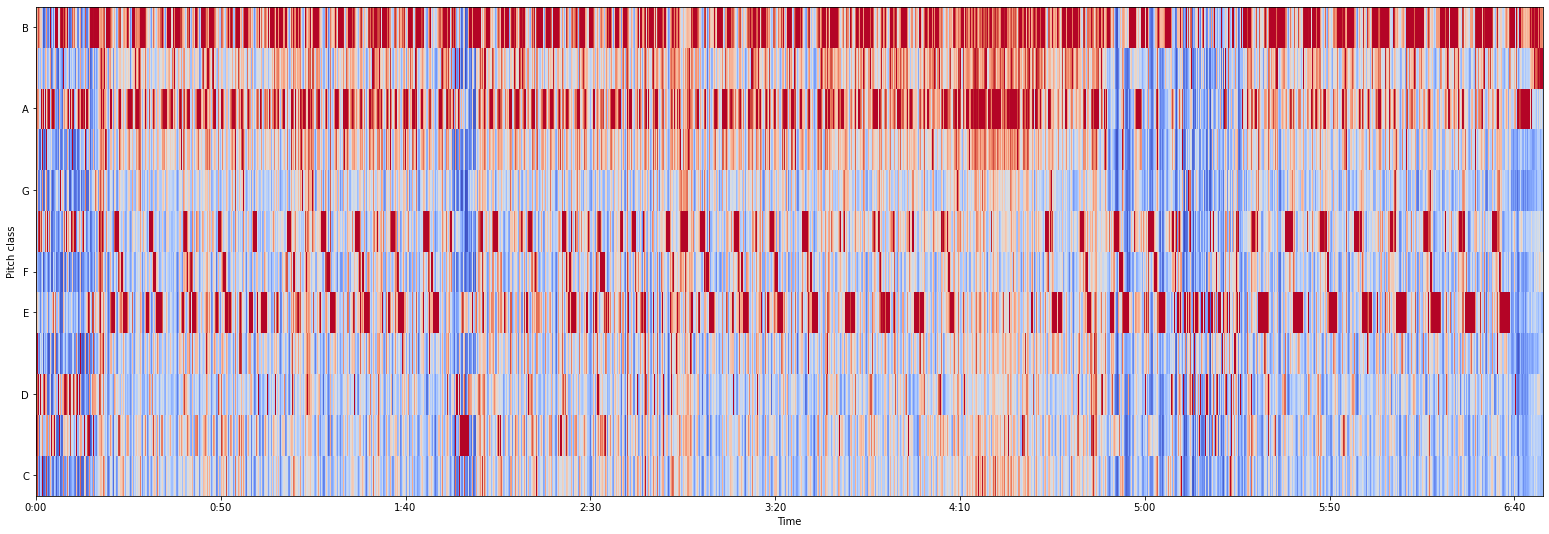

In [19]:
plt.figure(figsize=(27, 9))
lib.display.specshow(dua_chroma, x_axis='time', y_axis='chroma', hop_length=hop, cmap='coolwarm');

In [20]:
majj, minn = key_estimator(joey)

In [21]:
majj[0]

4

In [22]:
pitches, magnitudes = lib.piptrack(joey, sr=sr, n_fft=frame, hop_length=hop)

In [23]:
pitches.mean()

8.845323

---

#### Spectral Centroid

The spectral centroid of an audio file is somewhat like a center of mass for the overall frequency response of the recording. It can aid in determining brightness or dullness in a signal by showing where the energy is most concentrated.

In [24]:
james_spc = lib.feature.spectral_centroid(james_blake, sr=sr, hop_length=hop, n_fft=frame)

In [25]:
james_spc.mean()

1869.303815682425

In [26]:
joey_spc = lib.feature.spectral_centroid(joey, sr=sr, hop_length=hop, n_fft=frame)

In [27]:
joey_spc

array([[2131.56019005, 2028.98282175, 2115.52748994, ..., 2807.01439917,
        2628.29824089, 2413.75565449]])

In [28]:
joey_spc.mean()

2940.9440538331014

The higher mean suggests this track, *Paper Trails*, is a brighter track, which I'd agree with from a perceptual standpoint.

---

**BELOW:** Using Librosa's `.hpss()` method to separate harmonic and percussive elements from tracks.

In [29]:
dua_harmonic, dua_percussive = lib.effects.hpss(dua_lipa, margin=2)

In [30]:
# Using Librosa's .chroma_stft() method to compute a chromagram vector for a few test tracks
dua_chroma3 = lib.feature.chroma_stft(dua_harmonic, sr=sr, n_fft=frame, hop_length=hop, window=sp.signal.windows.hann)

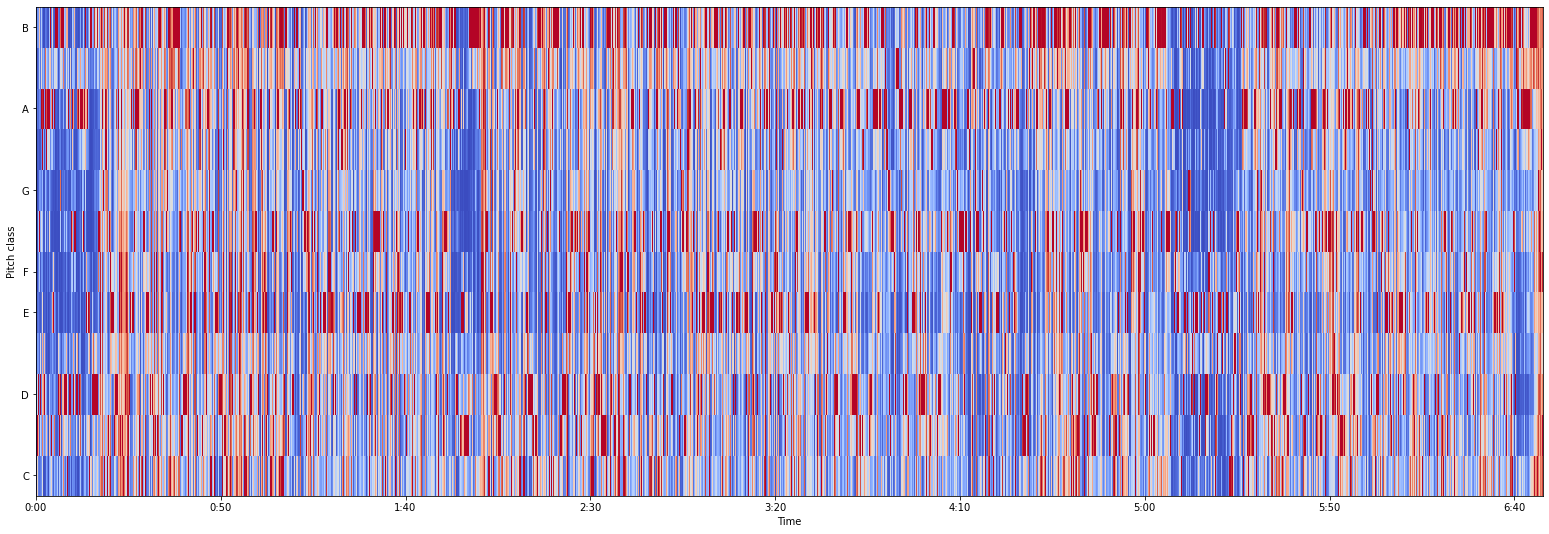

In [31]:
plt.figure(figsize=(27, 9))
lib.display.specshow(dua_chroma3, x_axis='time', y_axis='chroma', hop_length=hop, cmap='coolwarm');

In [32]:
dua_chroma4 = lib.feature.chroma_cqt(dua_harmonic, sr=sr, hop_length=hop)

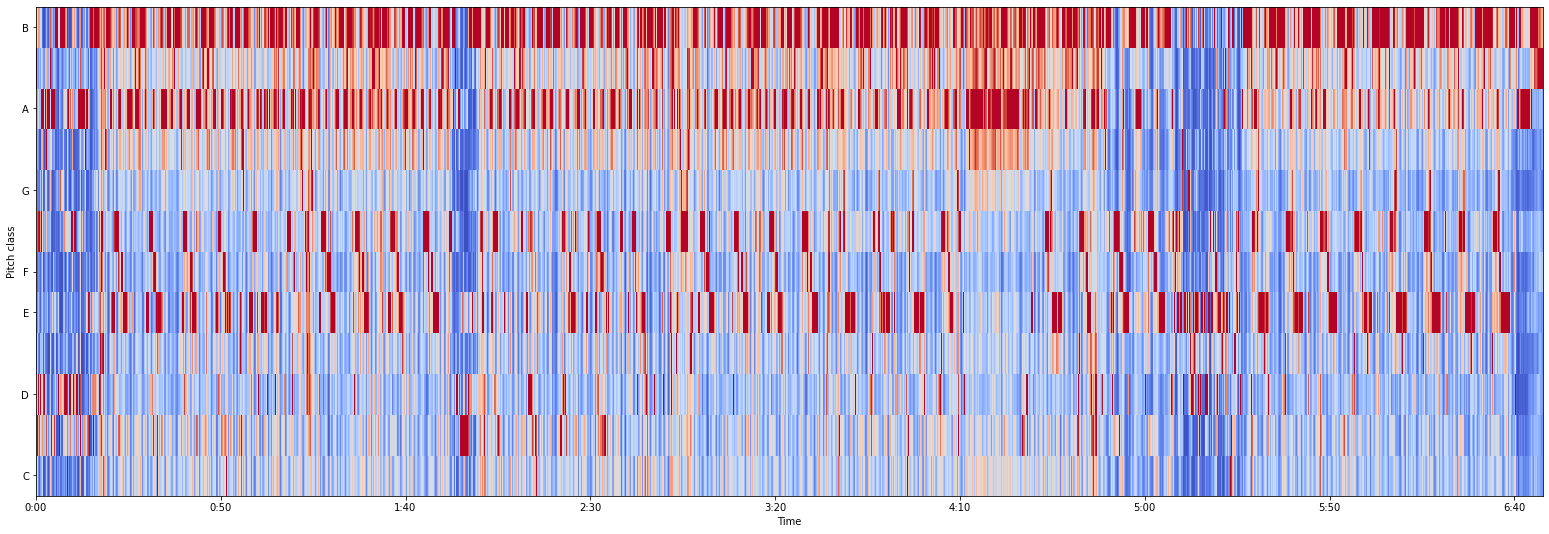

In [33]:
plt.figure(figsize=(27, 9))
lib.display.specshow(dua_chroma4, x_axis='time', y_axis='chroma', hop_length=hop, cmap='coolwarm');

---

**BELOW:** Looking at RMS loudness.

In [34]:
james_rms = lib.feature.rms(james_blake, frame_length=frame, hop_length=hop)

In [35]:
james_rms.mean()

0.18225987

In [36]:
df['loudness'][43245]

-11.283

In [37]:
dua_rms = lib.feature.rms(dua_lipa, frame_length=frame, hop_length=hop)

In [38]:
dua_rms.mean()

0.31246346

In [39]:
df['loudness'][55871]

-2.278

---

In [40]:
# Generating short time Fourier Transform coefficients
james_stft = lib.stft(james_blake, hop_length=hop, n_fft=frame)

In [41]:
james_stft.shape

(1025, 19260)

In [42]:
# Generating an array representing a mel-scaled spectrogram for James Blake
james_mel = lib.feature.melspectrogram(james_blake, sr=sr, n_fft=frame, hop_length=hop)

In [43]:
james_mel.shape

(128, 19260)

In [44]:
james_log_mel = lib.power_to_db(james_mel)

In [45]:
james_log_mel.mean()

-20.520113

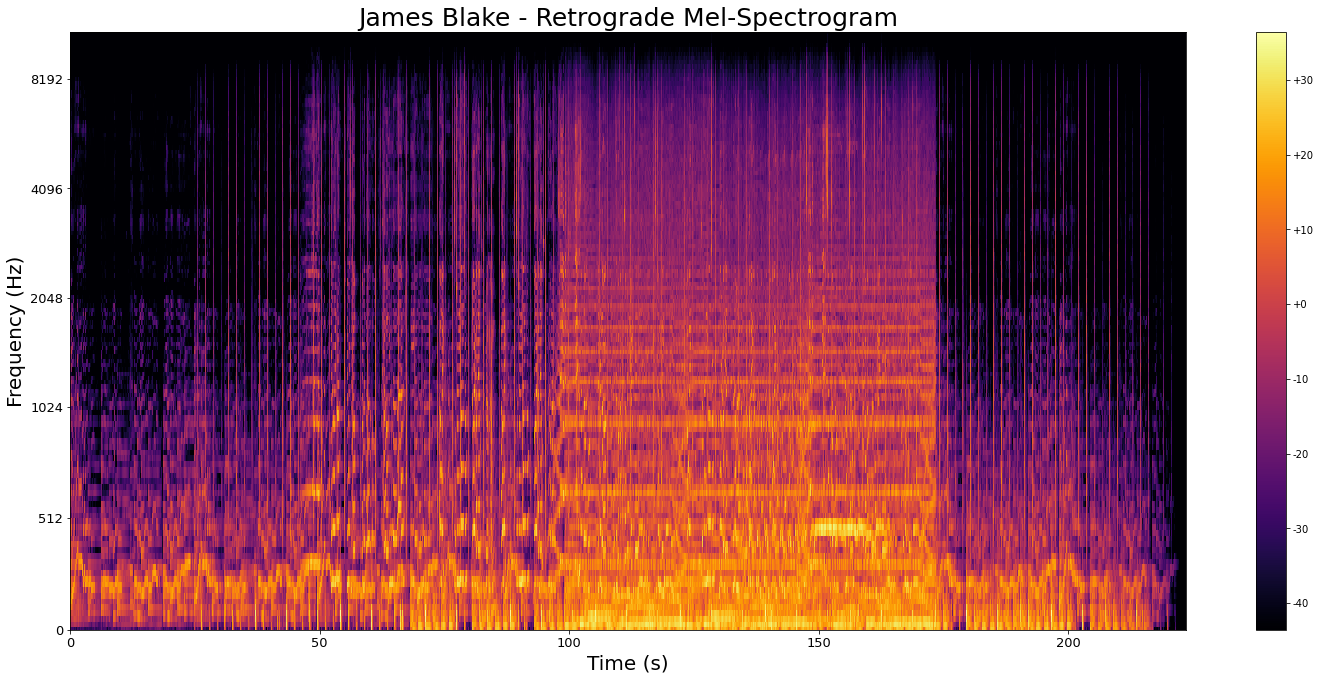

In [47]:
# Plotting the mel-spectrogram
plt.figure(figsize=(25, 11))

lib.display.specshow(james_log_mel, sr=sr, hop_length=hop, x_axis='s', y_axis='mel', cmap='inferno')

plt.colorbar(format='%+2.f')
plt.xlabel('Time (s)', size=20)
plt.xticks(size=13)
plt.ylabel('Frequency (Hz)', size=20)
plt.yticks(size=13)
plt.title('James Blake - Retrograde Mel-Spectrogram', size=25)
plt.show();